# Introdução

Apesar do agro gerar muito lucro, a vida dos agricultores não é fácil, mas sim um verdadeiro teste de resistência e determinação. Uma vez que tenhamos semeado as sementes, o agricultor precisa trabalhar dia e noite para garantir uma boa safra no final da estação. Uma boa colheita depende de diversos fatores, como disponibilidade de água, fertilidade do solo, proteção das culturas, uso oportuno de pesticidas, outros fatores químicos úteis e da natureza.

​ Muitos desses dados são quase impossíveis de se controlar, mas a quantidade e a frequência de pesticidas é algo que o agricultor pode administrar. Os pesticidas podem proteger a colheita com a dosagem certa. Mas, se adicionados em quantidade inadequada, podem prejudicar toda a safra.

​ Dito isto, abaixo são fornecidos dados baseados em culturas colhidas por vários agricultores no final da safra de 2018-2019. Para simplificar o problema, você pode assumir que todos os fatores relacionados as técnicas agrícolas e climáticas, não influenciaram esses resultados.

​ Seu objetivo neste exercício é determinar o resultado desta safra atual de 2020, ou seja, se a colheita será saudável, prejudicada por pesticidas, ou prejudicada por outros motivos.

In [45]:
import pandas as pd
import numpy as np
import seaborn as sns
from dython.nominal import associations
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objects as go
import chart_studio.plotly as py
import scipy.stats as ss

from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, normalize 

from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics


#carregar os dados
train = pd.read_csv('Safra_2018-2019.csv.txt')
test = pd.read_csv('Safra_2020.csv.txt')
train.head()

,Unnamed: 0,Identificador_Agricultor,Estimativa_de_Insetos,Tipo_de_Cultivo,Tipo_de_Solo,Categoria_Pesticida,Doses_Semana,Semanas_Utilizando,Semanas_Sem_Uso,Temporada,dano_na_plantacao
0,0,SCROP00001,188,1,0,1,0,0.0,0,1,0
1,1,SCROP00002,209,1,0,1,0,0.0,0,2,1
2,2,SCROP00003,257,1,0,1,0,0.0,0,2,1
3,3,SCROP00004,257,1,1,1,0,0.0,0,2,1
4,4,SCROP00005,342,1,0,1,0,0.0,0,2,1


In [46]:
train.shape

(80000, 11)

In [47]:
test.shape

(8858, 10)

# 1) Análise e Pré-Processamento dos Dados

São 10 variáveis presentes no Dataset, na qual apenas uma variável possui dados faltando (Nan). Em primeira análise, podemos deletar as variáveis **Unnamed:0** e **Identificador_Agricultor**, pois são variáveis únicas que representam cada agricultor, ou seja, um ID.  
As variáveis presentes no Dataset:
- **Identificador_Agricultor** - IDENTIFICADOR DO CLIENTE
- **Estimativa_de_Insetos** -	Estimativa de insetos por M²
- **Tipo_de_Cultivo** -	Classificação do tipo de cultivo (0,1)
- **Tipo_de_Solo** -	Classificação do tipo de solo (0,1)
- **Categoria_Pesticida** -	Informação do uso de pesticidas (1- Nunca Usou, 2-Já Usou, 3-Esta usando)
- **Doses_Semana** -	Número de doses por semana
- **Semanas_Utilizando** -	Número de semanas Utilizada
- **Semanas_Sem_Uso** -	Número de semanas sem utilizar
- **Temporada** -	Temporada Climática (1,2,3)
- **dano_na_plantacao** -	Variável de Predição - Dano no Cultivo (0=Sem Danos, 1=Danos causados por outros motivos, 2=Danos gerados pelos pesticidas)

In [48]:
data = pd.DataFrame({'colunas' : train.columns,
                    'tipo': train.dtypes,
                    'missing' : train.isna().sum(),
                    'size' : train.shape[0],
                    'unicos': train.nunique()})
data['percentual'] = round(data['missing'] / data['size'],3)

data

,colunas,tipo,missing,size,unicos,percentual
Unnamed: 0,Unnamed: 0,int64,0,80000,80000,0.000
Identificador_Agricultor,Identificador_Agricultor,object,0,80000,80000,0.000
Estimativa_de_Insetos,Estimativa_de_Insetos,int64,0,80000,71,0.000
Tipo_de_Cultivo,Tipo_de_Cultivo,int64,0,80000,2,0.000
Tipo_de_Solo,Tipo_de_Solo,int64,0,80000,2,0.000
Categoria_Pesticida,Categoria_Pesticida,int64,0,80000,3,0.000
Doses_Semana,Doses_Semana,int64,0,80000,20,0.000
Semanas_Utilizando,Semanas_Utilizando,float64,8055,80000,64,0.101
Semanas_Sem_Uso,Semanas_Sem_Uso,int64,0,80000,51,0.000
Temporada,Temporada,int64,0,80000,3,0.000


In [49]:
#dropar algumas colunas
train = train.drop(['Unnamed: 0', 'Identificador_Agricultor'], axis=1)
test = test.drop(['Unnamed: 0', 'Identificador_Agricultor'], axis=1)

### 1.1) Analisando a variável com Nan ( Semanas_Utilizando)

Fazendo um histograma e calculando a média, mediana e moda, veremos que a variável **Semanas_Utilizando** não segue uma distribuição normal. A maior quantidade de Semanas Utilizando o pesticida se dá entre 20 e 40 semanas. Logo, para lidar com os dados faltantes desta variável (cerca de 10% dos dados de treinamento), podemos substituir pela média, por 0 (considerando que não foi utilizado pesticida) ou por -1 (dependendo da escolha do modelo).

In [50]:
missing = train.Semanas_Utilizando

print('Média: {:.2f} \nMediana: {} \nModa: {}'.format(missing.mean(), missing.median(), missing.mode()[0]))

Média: 28.66 
Mediana: 28.0 
Moda: 20.0


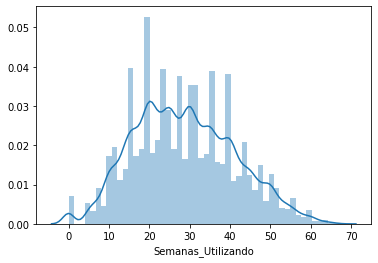

In [51]:
#histogram
sns.distplot(train.Semanas_Utilizando);

### 1.2) Analizando outras variáveis

Um visão geral na relação das variáveis nos leva a notar a existência de algumas correlações que podem ser melhor analisadas segmentadas com os **danos na plantação**. Por exemplo:
- **Estimativa de inseto** por **Doses Semanais**, **Semanas utilizando** e **Semanas sem uso**
- **Categoria do pesticida** por **Doses Semanais**, **Semana Utilizando** e **Semana sem Uso**
- **Doses Semanais** por **Semana Utilizando**
- **Semanas Utilizando** por **Semanas Sem Uso**
- e por fim uma análise na variável alvo **dano na plantação.

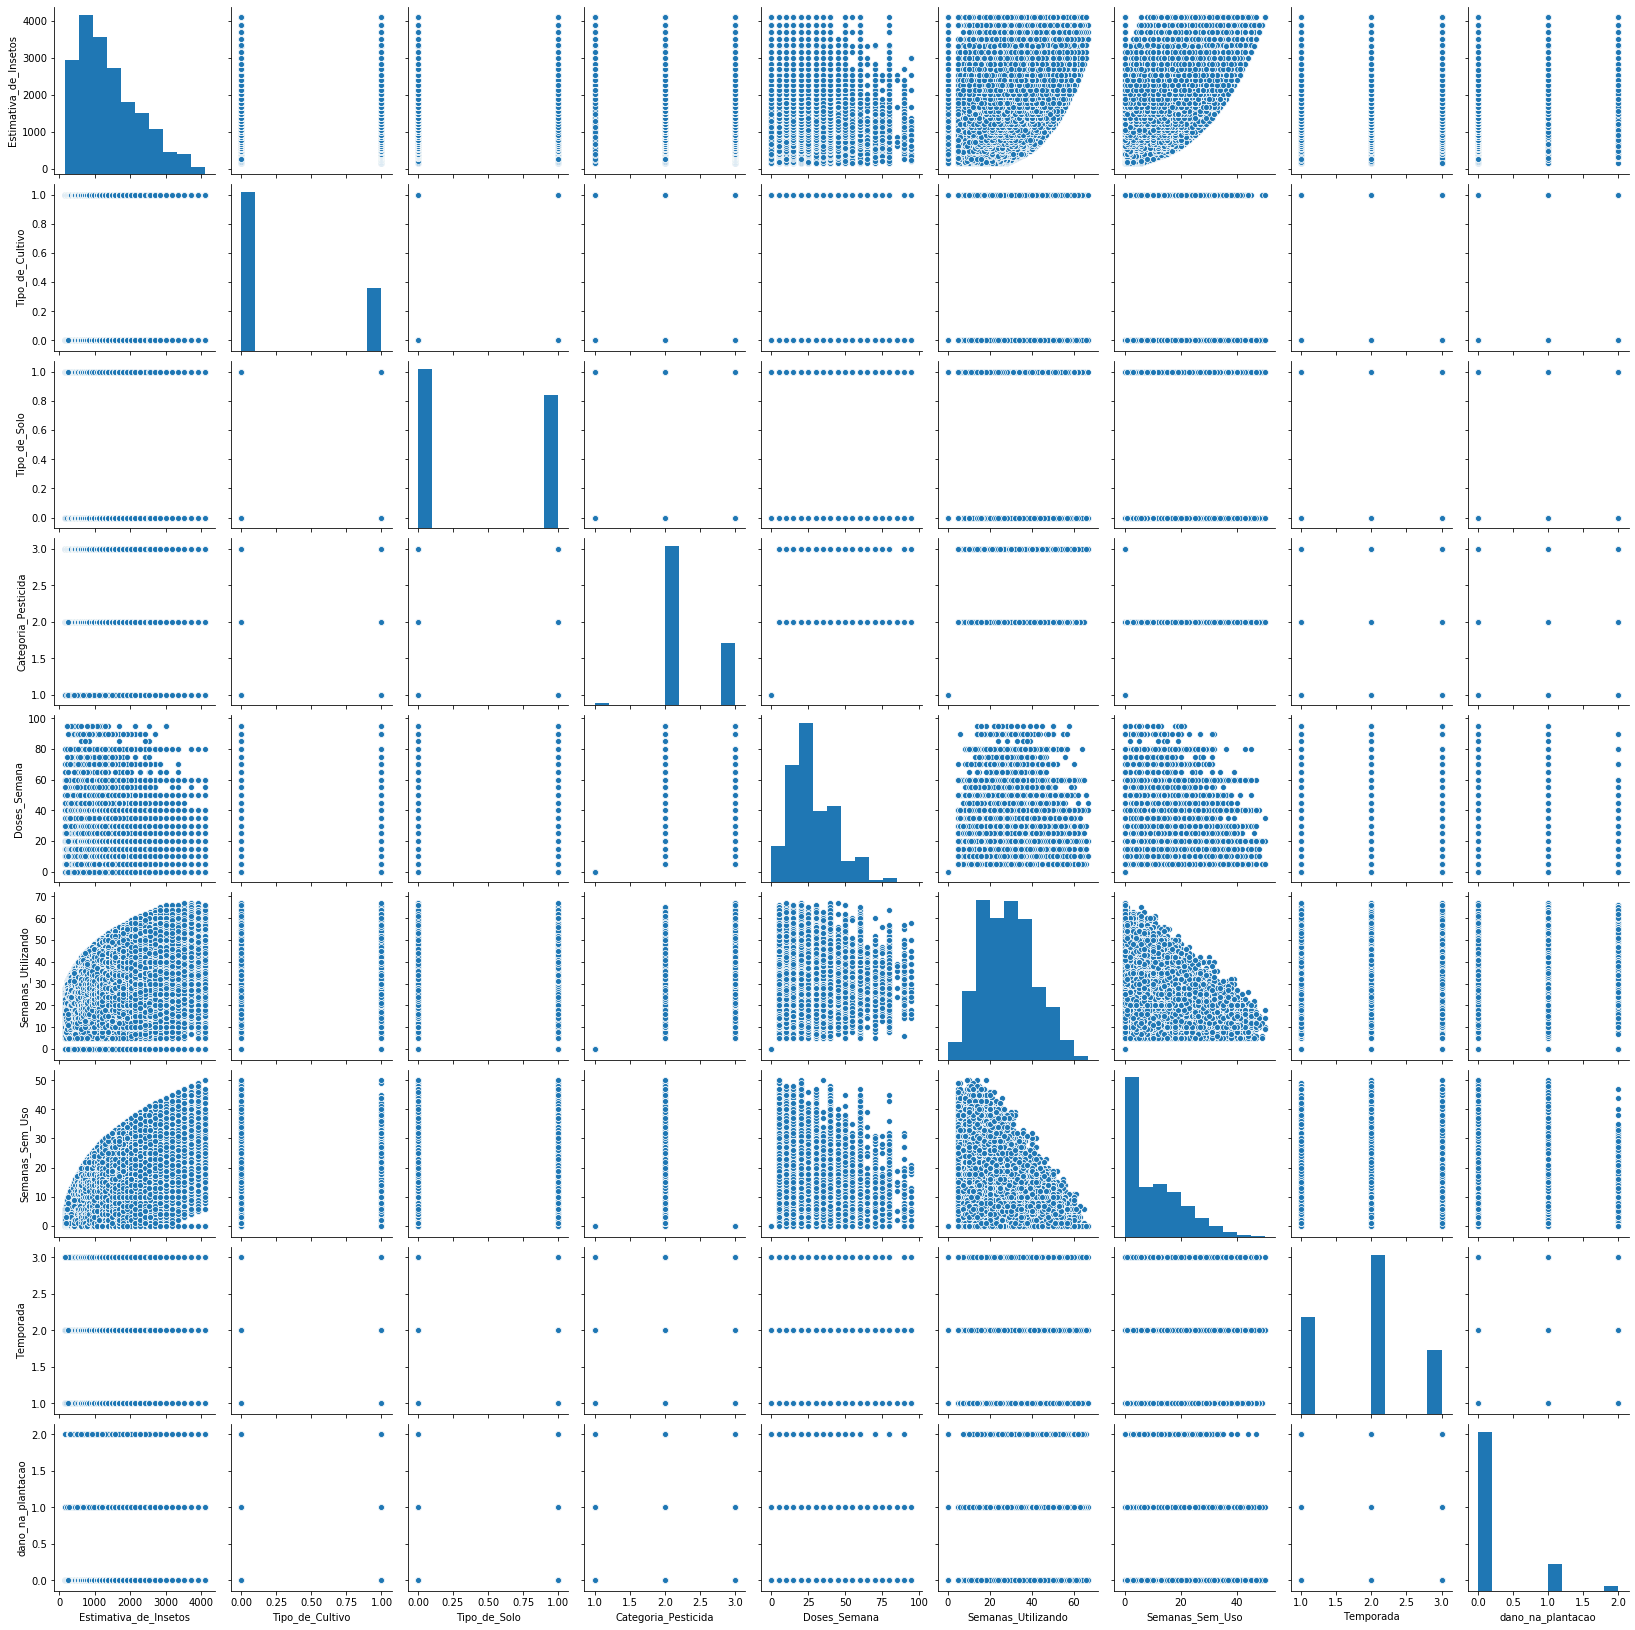

In [52]:
sns.pairplot(train);

#### 1.2.1) Estimativa de Insetos

Nos gráficos iniciais, chamaram a atenção a relação entre a **Estimativa de Insetos** e **Semanas Utilizando**. Aparentemente, há uma relação entre essas variáveis, quanto maior a **estimativa de insetos**, maior o número de **semanas Utilizando** o pesticída, assim como, maior a quantidade de **Semanas sem Uso**. Já para visualizar a relação entre a **Estimativa de Insetos** e as **Doses Semanais**, é difícil enxergar relações. 

Em ambos os casos, não é fácil segmentar o **dano na plantação**.

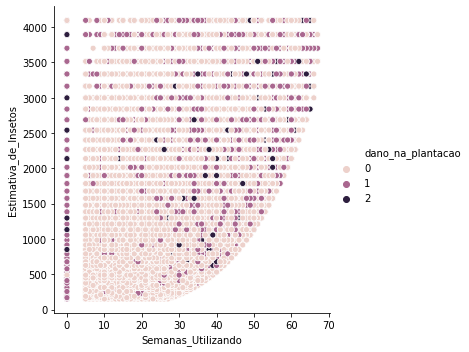

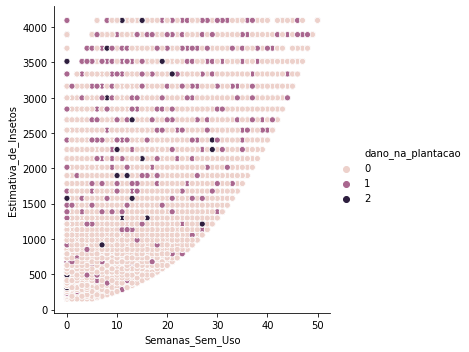

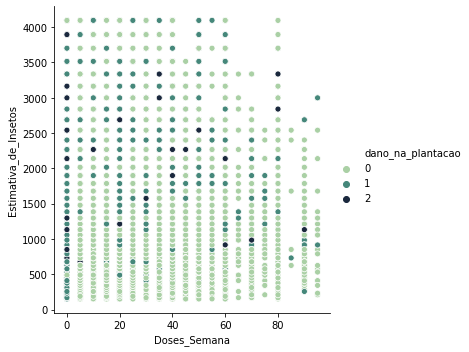

In [53]:
sns.relplot(x="Semanas_Utilizando", y="Estimativa_de_Insetos", hue="dano_na_plantacao", data=train);

sns.relplot(x="Semanas_Sem_Uso", y="Estimativa_de_Insetos", hue="dano_na_plantacao", data=train);

sns.relplot(x="Doses_Semana", y="Estimativa_de_Insetos", hue="dano_na_plantacao", data=train, palette="ch:r=-.5,l=.75");

#### 1.2.2) Categoria Pesticida

Considerando a **Categoria do Pesticida**, aparentemente há uma relação com o **dano na plantação**, se utilizarmos o teste de Cramer’s V teremos um valor da associação entre as duas variáveis. Além disso, o número de dados com **categoria do pesticida** igual a 1 é cerca de 1%.

Algumas considerações:
- Em relação a **Semanas sem uso**, apenas uma categoria de pesticida (categoria 2) tem variações na quantidade de semanas;
- Para **Doses Semanais**, há dados, com variações para a categoria de pesticida 2 e 3, com danos de **danos na plantação** causados por pesticidas na categoria 1 e 3 de tipos de pesticidas;
- Já para **Semanas Utilizando**, há uma relação crescente no número de semanas utilizando pesticidas em relação ao tipo de pesticida. Pesticidas do tipo 3 tem, em média, um maior numero de semanas de uso. 

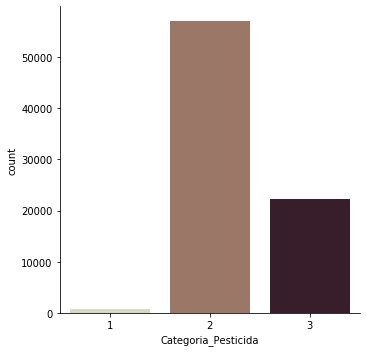

In [54]:
sns.catplot(x="Categoria_Pesticida", kind="count", data=train, palette="ch:.5");

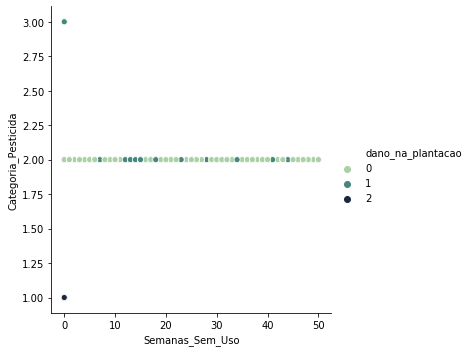

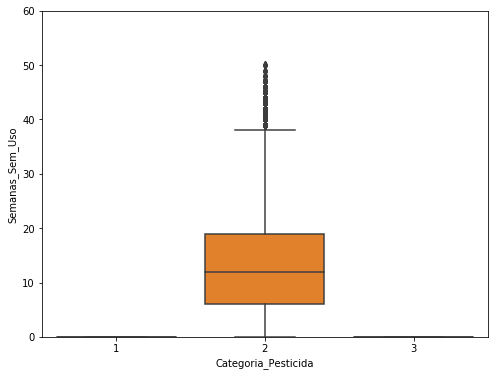

In [55]:
sns.relplot(x="Semanas_Sem_Uso", y="Categoria_Pesticida", hue="dano_na_plantacao", data=train, palette="ch:r=-.5,l=.75");


#box plot
var1 = 'Categoria_Pesticida'
var2 = 'Semanas_Sem_Uso'
data = pd.concat([train[var2], train[var1]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var1, y=var2, data=data)
fig.axis(ymin=0, ymax=60);

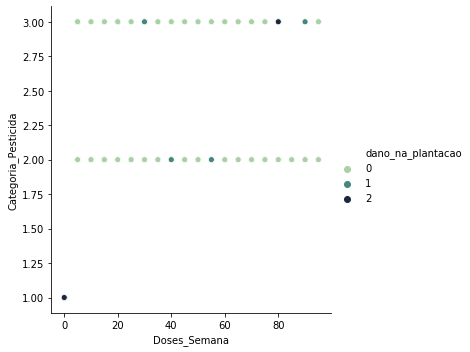

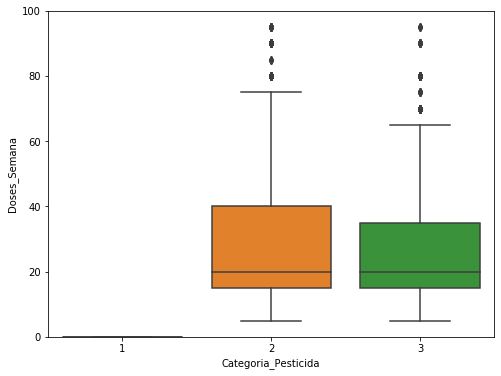

In [56]:
sns.relplot(x="Doses_Semana", y="Categoria_Pesticida", hue="dano_na_plantacao", data=train, palette="ch:r=-.5,l=.75");

#box plot
var1 = 'Categoria_Pesticida'
var2 = 'Doses_Semana'
data = pd.concat([train[var2], train[var1]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var1, y=var2, data=data)
fig.axis(ymin=0, ymax=100);

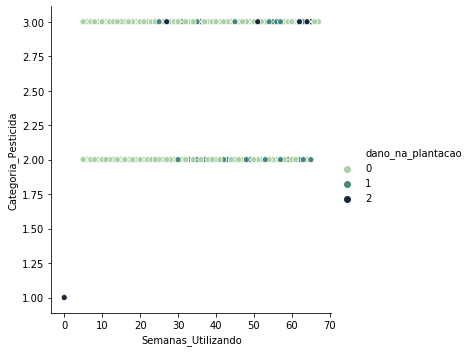

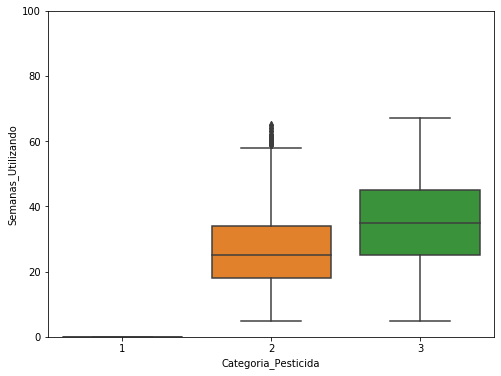

In [57]:
sns.relplot(x="Semanas_Utilizando", y="Categoria_Pesticida", hue="dano_na_plantacao", data=train, palette="ch:r=-.5,l=.75");

#box plot
var1 = 'Categoria_Pesticida'
var2 = 'Semanas_Utilizando'
data = pd.concat([train[var2], train[var1]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var1, y=var2, data=data)
fig.axis(ymin=0, ymax=100);

#### 1.2.3) Doses Semanais

Acredito na hipótese de que **Doses Semanais** é uma variável categorica do tipo **Ordinal**. 

Em relação ao **dano na planação**, aparentemente há uma relação com a quantidade de doses semanais. A frequência de danos na plantação se concentra entre 0 a 60 doses semanais. 
Também se observamos a relação com **Semanas Utilizando**, veremos que os danos batem com o número maior de semanas utilizando o pesticidas.

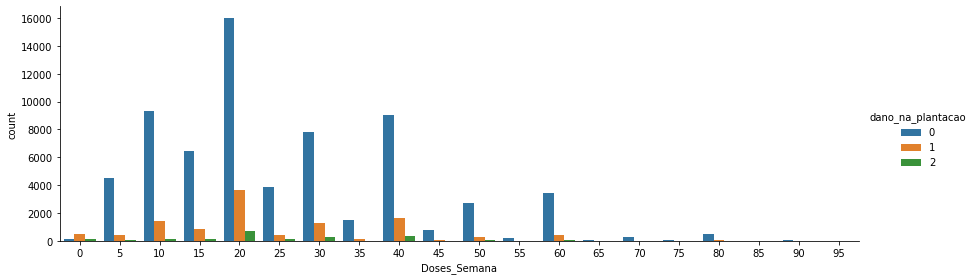

In [58]:
sns.catplot("Doses_Semana", hue="dano_na_plantacao", data=train, kind="count", height=4, aspect=3)

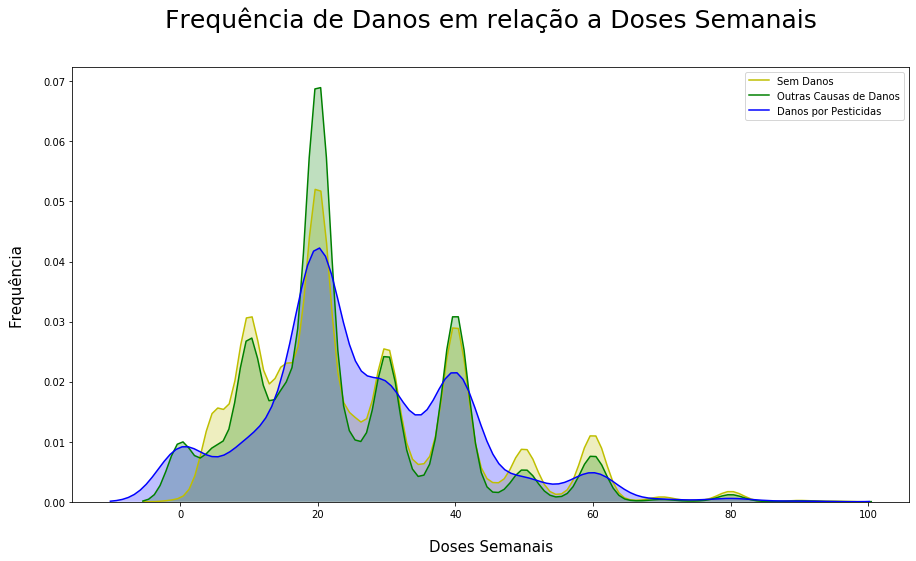

In [59]:
# Kernel Density Plot
fig = plt.figure(figsize=(15,8),)
ax=sns.kdeplot(train.loc[(train['dano_na_plantacao'] == 0),'Doses_Semana'] , color='y',shade=True,label='Sem Danos')
ax=sns.kdeplot(train.loc[(train['dano_na_plantacao'] == 1),'Doses_Semana'] , color='g',shade=True, label='Outras Causas de Danos')
ax=sns.kdeplot(train.loc[(train['dano_na_plantacao'] == 2),'Doses_Semana'] , color='b',shade=True, label='Danos por Pesticidas')
plt.title('Frequência de Danos em relação a Doses Semanais', fontsize = 25, pad = 40)
plt.xlabel("Doses Semanais", fontsize = 15, labelpad = 20)
plt.ylabel('Frequência', fontsize = 15, labelpad= 20);

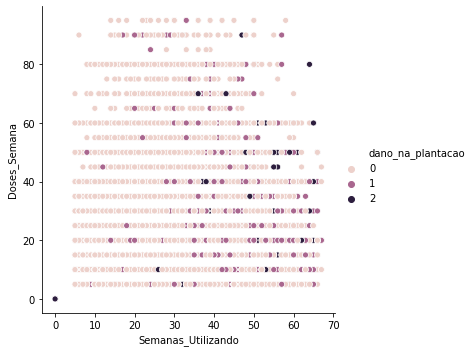

In [60]:
sns.relplot(x="Semanas_Utilizando", y="Doses_Semana", hue="dano_na_plantacao", data=train);

#### 1.2.4) Semanas Utilizando vs Semanas Sem Uso

A relação entre **Semanas Utilizando** e **Semanas sem uso** se torna bem interessante junto com o **dano na plantação**. Quando temos um número alto de semanas utilizando pesticidas e, consequentemente, um número baixo sem utilizar, há danos na plantação (seja por pesticidas ou outros tipos). Já se ocorrer um número baixo de semanas utilizando pesticidas om um número alto de semanas sem uso, há a tendência de não haver dano na plantação ou ocorrer outros tipos de danos. 

Podemos perceber, também, a presença de OutLiers nos dados. Assim como nas outras visualizações.

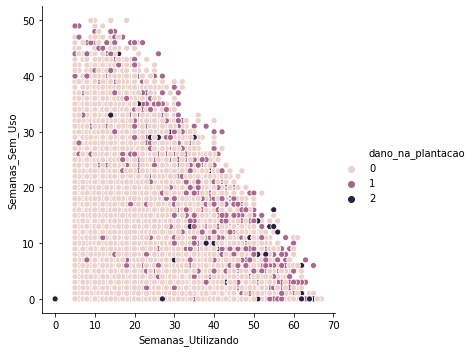

In [61]:
sns.relplot(x="Semanas_Utilizando", y="Semanas_Sem_Uso", hue="dano_na_plantacao", data=train);

#### 1.2.5) Dano na Plantação

Em relação a variável alvo (**Dano na plantação**), veremos que os dados são desbalanceados. Há uma quantidade expressiva de dados onde não há dano. Já em relação aos danos, é uma pequena quantidade. Também é possível perceber uma relação entre essa variável e as variáveis **Semanas Utilizando**, **Semanas sem Uso**, **Estimativas de Insetos**, dentre outras já citadas e que será novamente observadas.

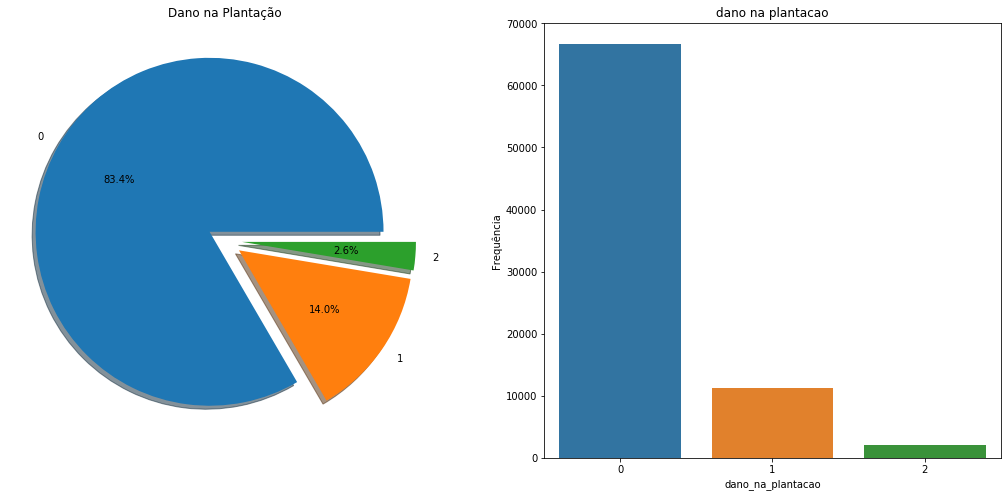

In [62]:
f,ax=plt.subplots(1,2,figsize=(18,8))
train['dano_na_plantacao'].value_counts().plot.pie(explode=[0.1,0.1, 0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('Dano na Plantação')
ax[0].set_ylabel('')
sns.countplot('dano_na_plantacao',data=train,ax=ax[1])
ax[1].set_title('dano na plantacao')
ax[1].set_ylabel('Frequência')
plt.show()

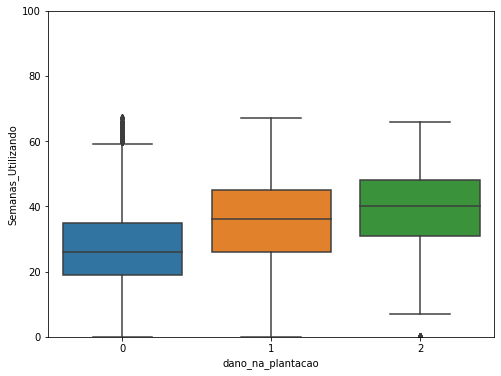

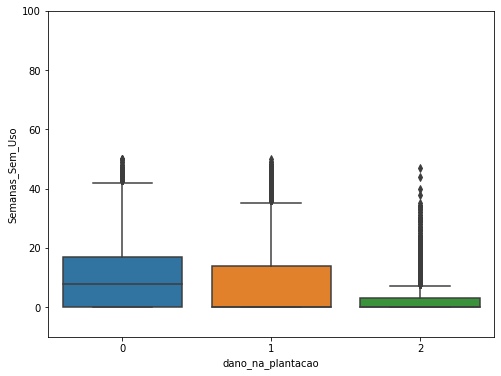

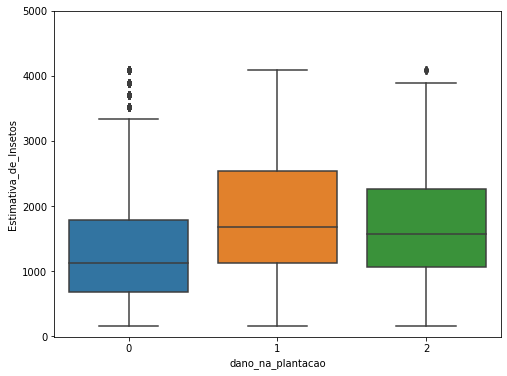

In [63]:
#box plot
var1 = 'dano_na_plantacao'
var2 = 'Semanas_Utilizando'
data = pd.concat([train[var2], train[var1]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var1, y=var2, data=data)
fig.axis(ymin=0, ymax=100);

var2 = 'Semanas_Sem_Uso'
data = pd.concat([train[var2], train[var1]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var1, y=var2, data=data)
fig.axis(ymin=-10, ymax=100);

var2 = 'Estimativa_de_Insetos'
data = pd.concat([train[var2], train[var1]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var1, y=var2, data=data)
fig.axis(ymin=-10, ymax=5000);

### 1.3) Correlação entre as variáveis 

Calculando a correlação entre as variáveis, veremos que as análises anteriores fazem sentido para alguns casos. Note que há uma correlação fraca entre a variável alvo **dano na plantação** e as variáveis **Estimativa de Inseto**, **Categoria Pesticida**, **Semanas Utilizando** e **Semanas sem Uso**. Porém, para algumas variáveis (categóricas) farei uso do **Cramer's V** como na função abaixo ou através de uma melhoria deste método pelo pacote **dython**.

Se observarmos a variável **Doses Semanais** pela correlação abaixo (pairwise correlation) não haveria relação com o **dano na plantação**, confrontando nossa análise anterior. A partir disso, acredito na hipótese de que essa variável é categórica ordinal. Desta forma, fazendo uma análise de categórica para categórica teremos uma real noção da sua relação com a variável alvo.

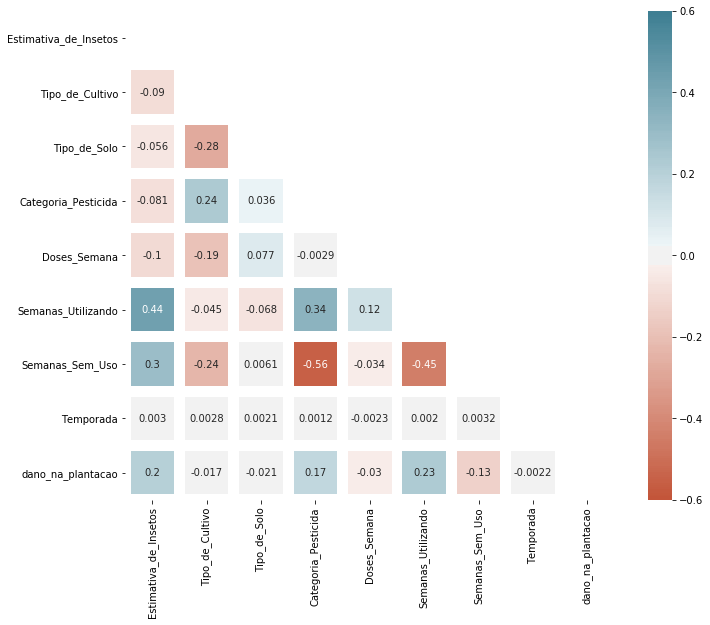

In [64]:
#correlation matrix
corrmat = train.corr()
mask=np.zeros_like(corrmat)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmin=-.6, vmax=.6, center=0, square=True, annot=True, 
            cmap=sns.diverging_palette(20, 220, n=200), linewidths=10, mask=mask);

De acordo com a correlação de **Cramer's V**, a variável **Doses Semanais** tem correlação fraca com a variável alvo.

In [65]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [66]:
cramers_v(train['Doses_Semana'], train['dano_na_plantacao'])

0.15425542370152912

Fazendo um novo calculo de correlação, levando em consideração as variáveis categóricas, apenas as variáveis **Tipo de Cultivo**, **Tipo de Solo** e **Temporada** terão uma correlação quase nula com a variável alvo **dano na plantação**. 

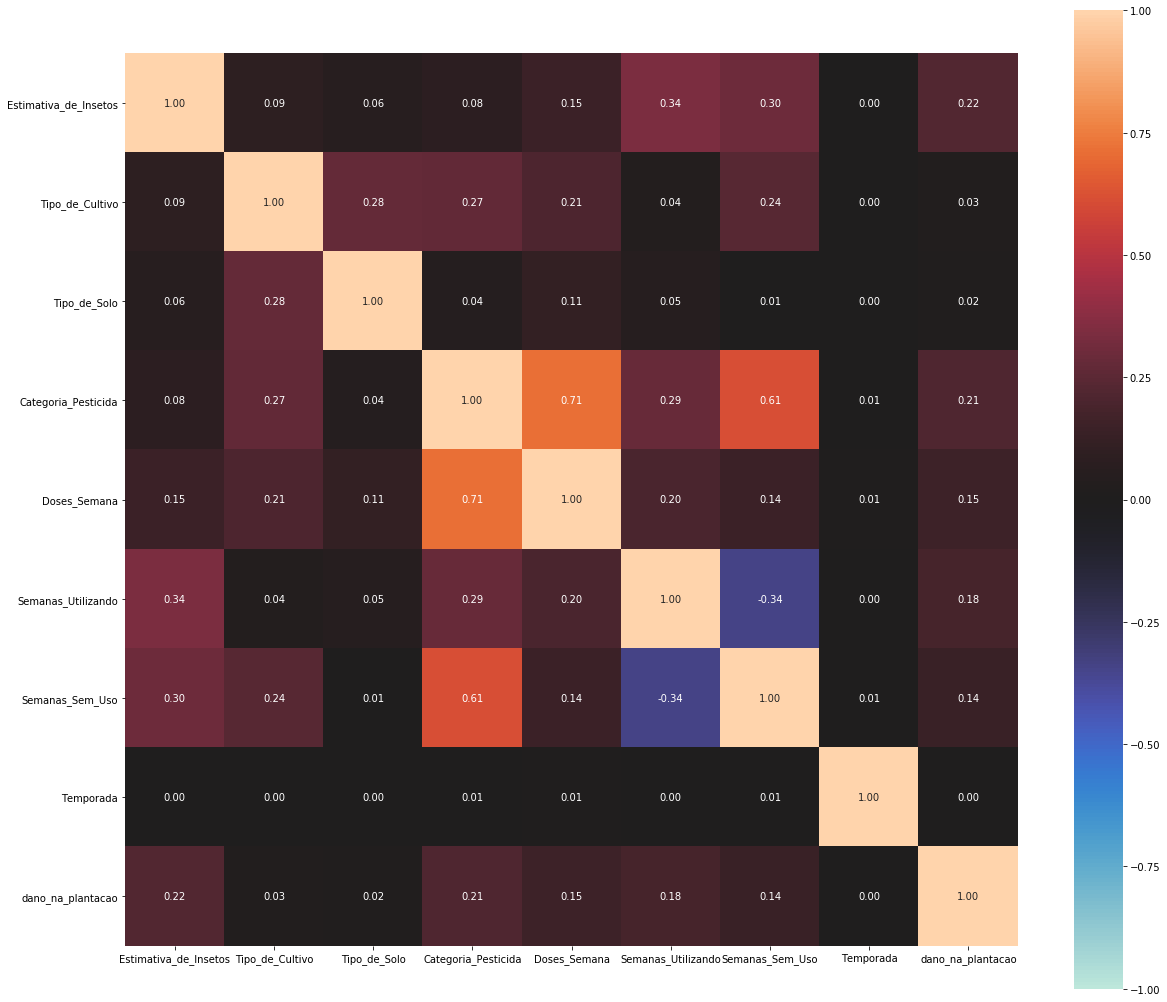

In [67]:
mt, ax = associations(train, nominal_columns=['Tipo_de_Cultivo', 'Categoria_Pesticida', 'Temporada', 'Tipo_de_Solo',
                                             'dano_na_plantacao', 'Doses_Semana'], figsize=(20, 18))

### 1.4) Pré Processamento dos dados

In [68]:
#Preenchendo os valores Nan com -1
train = train.fillna(-1)
test = test.fillna(-1)

In [69]:
#One Hot Encoding
categorical = ['Temporada','Categoria_Pesticida']

train = pd.get_dummies(train, columns=categorical, drop_first=True)
test = pd.get_dummies(test, columns=categorical, drop_first=True)

In [70]:
y = train.dano_na_plantacao
train = train.drop(['dano_na_plantacao'], axis=1)

# 2) Modelagem 

### 2.1) Baseline - Random Forest Classifier

Construirei um primeiro modelo (Baseline) utilizando o Random Forest com todas as features. Note que o modelo aprende e classifica muito bem para **dano na plantação** igual a 0(recall=0.95 e F1score=0.91), pois temos muitas variáveis para treino. Já para **dano na plantação** do tipo 1 e 2, recall e F1score é bem baixo, principalmente para o tipo 2 (dano por pesticida).

In [71]:
# dividing X, y into train and test data 
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.3, random_state = 0)

Accuracy: 0.8237083333333334


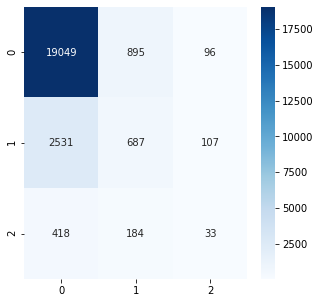

In [72]:
model = RandomForestClassifier(n_estimators=300)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

plt.figure(figsize = (5,5))
sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, cmap="Blues", fmt= 'g')
print('Accuracy:', metrics.accuracy_score(y_test,y_pred))

In [73]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.95      0.91     20040
           1       0.39      0.21      0.27      3325
           2       0.14      0.05      0.08       635

    accuracy                           0.82     24000
   macro avg       0.46      0.40      0.42     24000
weighted avg       0.78      0.82      0.80     24000



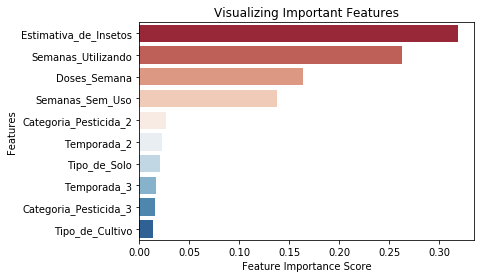

In [74]:
feature_imp = pd.Series(model.feature_importances_,index=train.columns).sort_values(ascending=False)

sns.barplot(x=feature_imp, y=feature_imp.index, palette="RdBu")
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

### 2.2)RandomForest e XGBOOST  com SMOTE

Uma opção que resolvi testar é fazer o redimensionamento dos dados. Como os dados para **dano na plantação** são desbalanceados (83% dos dados para 0), vamos aumentar os dados da classe menor (**dano na plantação** = 2). Acredito que o ideal seria fazer um aumento de 10 a 20% nos dados para **dano na plantação** igual a 1 e 2. Porém, não consegui utilizar o **SMOTE(sampling_strategy=0.1)** para o atual problema (multiclass). 

Desta forma, Ocorre uma redução na **accuracy**, porém há um aumento no **recall** e **F1-score** para os métodos utilizados.

In [75]:
from imblearn.over_sampling import SMOTE
import xgboost as xgb


smote = SMOTE(random_state=0)

X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

Accuracy: 0.7669166666666667


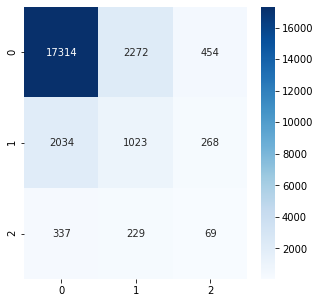

In [76]:
model = RandomForestClassifier(n_estimators=300)
model.fit(X_train_sm,y_train_sm)
y_pred = model.predict(X_test)

plt.figure(figsize = (5,5))
sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, cmap="Blues", fmt= 'g')
print('Accuracy:', metrics.accuracy_score(y_test,y_pred))

In [77]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.86      0.87     20040
           1       0.29      0.31      0.30      3325
           2       0.09      0.11      0.10       635

    accuracy                           0.77     24000
   macro avg       0.42      0.43      0.42     24000
weighted avg       0.78      0.77      0.77     24000



Utilizando um modelo mais robusto com os dados redimensionados:

In [78]:
# Sparametros do xgboost
params = {}
params['objective'] = 'multi:softprob'
params['eval_metric'] = 'mlogloss'
params['num_class'] = 3
params['eta'] = 0.02
params['max_depth'] = 4


d_train = xgb.DMatrix(X_train_sm, label=y_train_sm)
d_valid = xgb.DMatrix(X_test, label=y_test)

watchlist = [(d_train, 'train'), (d_valid, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=50, verbose_eval=10,maximize=False)

[0]	train-mlogloss:1.09137	valid-mlogloss:1.08888
Multiple eval metrics have been passed: 'valid-mlogloss' will be used for early stopping.

Will train until valid-mlogloss hasn't improved in 50 rounds.
[10]	train-mlogloss:1.02989	valid-mlogloss:1.00671
[20]	train-mlogloss:0.98385	valid-mlogloss:0.94547
[30]	train-mlogloss:0.94790	valid-mlogloss:0.89781
[40]	train-mlogloss:0.91847	valid-mlogloss:0.85963
[50]	train-mlogloss:0.89449	valid-mlogloss:0.82912
[60]	train-mlogloss:0.87448	valid-mlogloss:0.80393
[70]	train-mlogloss:0.85726	valid-mlogloss:0.78217
[80]	train-mlogloss:0.84255	valid-mlogloss:0.76465
[90]	train-mlogloss:0.83003	valid-mlogloss:0.75011
[100]	train-mlogloss:0.81914	valid-mlogloss:0.73766
[110]	train-mlogloss:0.80978	valid-mlogloss:0.72764
[120]	train-mlogloss:0.80163	valid-mlogloss:0.71921
[130]	train-mlogloss:0.79437	valid-mlogloss:0.71213
[140]	train-mlogloss:0.78728	valid-mlogloss:0.70600
[150]	train-mlogloss:0.78120	valid-mlogloss:0.70071
[160]	train-mlogloss:0.775

In [79]:
d_test = xgb.DMatrix(X_test)
yprob = bst.predict( d_test ).reshape( y_test.shape[0], 3)
y_pred = np.argmax(yprob, axis=1)

In [80]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.81      0.85     20040
           1       0.26      0.32      0.29      3325
           2       0.11      0.35      0.17       635

    accuracy                           0.73     24000
   macro avg       0.42      0.49      0.44     24000
weighted avg       0.79      0.73      0.76     24000



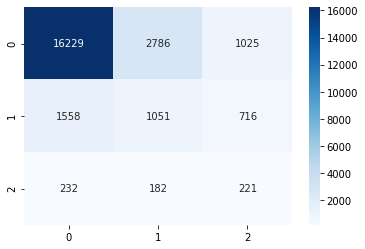

In [81]:
sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, cmap="Blues", fmt= 'g')

## Previsão dos dados de Teste

In [82]:
d_test = xgb.DMatrix(test)
yprob = bst.predict( d_test )#.reshape( y_test.shape[0], 3)
y_pred = np.argmax(yprob, axis=1)

test['dano_na_plantacao'] = y_pred

In [83]:
test

,Estimativa_de_Insetos,Tipo_de_Cultivo,Tipo_de_Solo,Doses_Semana,Semanas_Utilizando,Semanas_Sem_Uso,Temporada_2,Temporada_3,Categoria_Pesticida_2,Categoria_Pesticida_3,dano_na_plantacao
0,256,0,1,35,11.0,9,0,0,1,0,0
1,283,0,1,5,5.0,6,0,0,1,0,0
2,283,0,1,15,15.0,5,1,0,1,0,0
3,283,0,1,15,-1.0,7,1,0,1,0,0
4,283,0,1,15,19.0,2,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
8853,3337,1,0,10,12.0,44,0,1,1,0,0
8854,3516,1,0,10,20.0,38,0,0,1,0,0
8855,3516,1,0,15,40.0,8,1,0,1,0,0
8856,3702,1,0,10,25.0,18,0,1,1,0,0


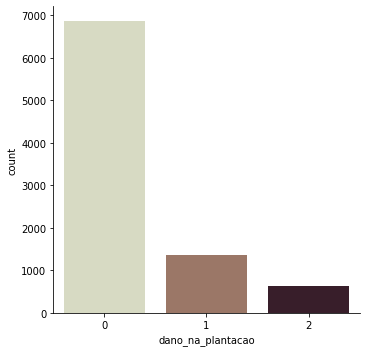

In [84]:
sns.catplot(x="dano_na_plantacao", kind="count", data=test, palette="ch:.5");

# 3) Considerações Finais

Foram feitas as anpalises, mais clara possível, nas variáveis do dataset. Levantando as correlações e variáveis que provavelmente não acrescentam valor na nossa modelagem. Apresento no gráfico abaixo uma visualização de todos os dados segmentados por **dano na plantação**.

Uma opção a ser testada é o **StratifiedKFold** com xgboost e um **SMOTE** seletivo nos dois dados minoritários da variável **danos na plantação**. 

## T-Distributed Stochastic Neighbouring Entities (t-SNE)

Utilizando t-SNE, farei uma tentativa de visualizar os dados. A partir desta visualização, segmentando os dados por **dano na plantação**, veremos que não há tantas regiões perfeitas para a classificação. 

In [85]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, normalize 

In [86]:
# Scaling the data so that all the features become comparable 
scaler = StandardScaler() 
X_scaled = scaler.fit_transform(train) 
  
# Normalizing the data so that the data approximately  
# follows a Gaussian distribution 
X_normalized = normalize(X_scaled) 
  
# Converting the numpy array into a pandas DataFrame 
X_normalized = pd.DataFrame(X_normalized, columns=train.columns)

In [87]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X_normalized)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 80000 samples in 0.464s...
[t-SNE] Computed neighbors for 80000 samples in 21.203s...
[t-SNE] Computed conditional probabilities for sample 1000 / 80000
[t-SNE] Computed conditional probabilities for sample 2000 / 80000
[t-SNE] Computed conditional probabilities for sample 3000 / 80000
[t-SNE] Computed conditional probabilities for sample 4000 / 80000
[t-SNE] Computed conditional probabilities for sample 5000 / 80000
[t-SNE] Computed conditional probabilities for sample 6000 / 80000
[t-SNE] Computed conditional probabilities for sample 7000 / 80000
[t-SNE] Computed conditional probabilities for sample 8000 / 80000
[t-SNE] Computed conditional probabilities for sample 9000 / 80000
[t-SNE] Computed conditional probabilities for sample 10000 / 80000
[t-SNE] Computed conditional probabilities for sample 11000 / 80000
[t-SNE] Computed conditional probabilities for sample 12000 / 80000
[t-SNE] Computed conditional probabilities for s

In [88]:
X_normalized['tsne-2d-one'] = tsne_results[:,0]
X_normalized['tsne-2d-two'] = tsne_results[:,1]

df = X_normalized.join(y)

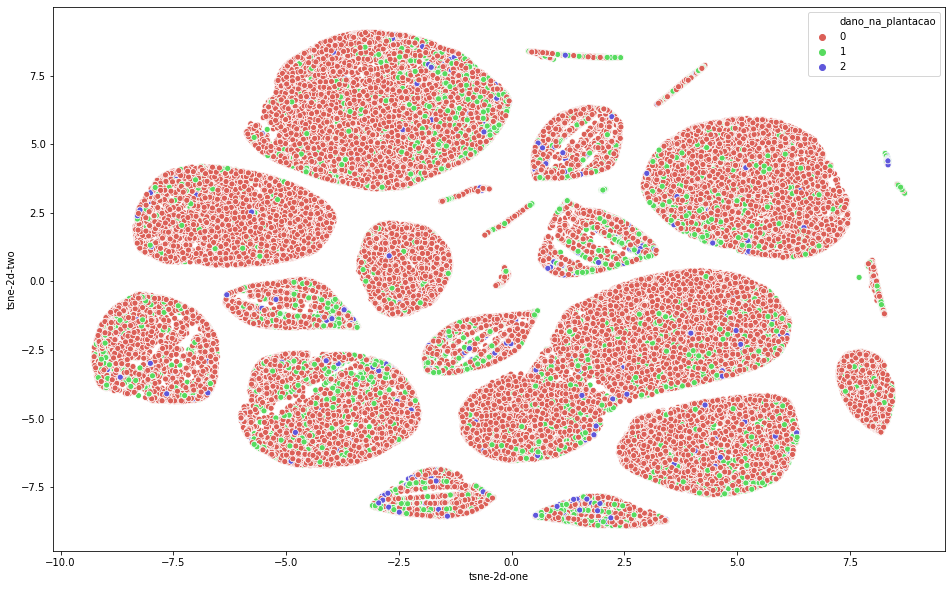

In [89]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="dano_na_plantacao",
    palette=sns.color_palette("hls", 3),
    data=df,
    legend="full"
)